In [116]:
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [117]:
pro = ts.pro_api()


In [118]:
# https://tushare.pro/document/2?doc_id=25
# get Constituents of SSE
data = pro.stock_basic(exchange='SSE', list_status='L',
                       fields='ts_code,symbol,name,area,industry,list_date')
# print(data.head())
# print(len(data))

# https://tushare.pro/document/2?doc_id=27
# the histories data of a stock
stock_data = pro.daily(ts_code='600000.SH',
                       start_date='20020901', end_date='20220901')
print(stock_data.head())
print(len(stock_data))


     ts_code trade_date  open  high   low  close  pre_close  change  pct_chg  \
0  600000.SH   20220901  7.23  7.29  7.20   7.23       7.27   -0.04  -0.5502   
1  600000.SH   20220831  7.17  7.28  7.15   7.27       7.19    0.08   1.1127   
2  600000.SH   20220830  7.14  7.20  7.13   7.19       7.15    0.04   0.5594   
3  600000.SH   20220829  7.16  7.21  7.12   7.15       7.22   -0.07  -0.9695   
4  600000.SH   20220826  7.23  7.26  7.18   7.22       7.20    0.02   0.2778   

         vol      amount  
0  232983.88  169134.999  
1  395661.30  286509.309  
2  225419.28  161534.933  
3  276003.24  197253.687  
4  175762.35  126876.441  
4747


In [119]:
# 予測変数:is_up
stock_data.groupby("change").size()
stock_data["is_up"] = stock_data["change"].map(lambda x: 1 if x > 0 else 0)
stock_data.groupby("is_up").size()

is_up
0    2449
1    2298
dtype: int64

In [120]:
pre_stock_data = pro.daily(
    ts_code='600000.SH', start_date='20020830', end_date='20220831')

stock_data["pre_open"] = pre_stock_data["open"]
stock_data["pre_high"] = pre_stock_data["high"]
stock_data["pre_low"] = pre_stock_data["low"]
stock_data["pre_vol"] = pre_stock_data["vol"]
stock_data["pre_amount"] = pre_stock_data["amount"]

# stock_data.info()

In [121]:
# Model: Logistic regression analysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 説明変数: T-1 (open high low close amount)
# X = stock_data[["pre_open", "pre_high", "pre_low", "pre_close", "amount"]]
X = stock_data[["pre_open", "pre_high", "pre_low", "pre_close"]]
X = stock_data[["pre_open", "pre_high", "pre_low", "pre_close", "vol", "amount"]]
Y = stock_data["is_up"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

model = LogisticRegression()
clf = model.fit(X_train, y_train)

print("train result:", clf.score(X_train, y_train))
print("test result:", clf.score(X_test, y_test))


train result: 0.5073033707865169
test result: 0.5012636899747261


In [122]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

clf = model.fit(X_train_std, y_train)
print("train:", clf.score(X_train_std, y_train))
print("test:", clf.score(X_test_std, y_test))


train: 0.5525280898876405
test: 0.5122156697556866


In [123]:
# 偏回帰係数
clf.coef_
# pre_high is the most

array([[-0.03672713,  0.5303701 ,  0.25883885, -0.7201131 ,  0.01573441,
         0.17212026]])

In [124]:
# Calculate the exponential of all elements in the input array.
np.exp(clf.coef_)


array([[0.96393913, 1.6995612 , 1.29542502, 0.48669721, 1.01585885,
        1.18782068]])

[-0.10228813]


ValueError: x and y must be the same size

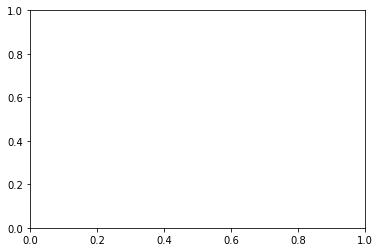

In [128]:
# 散布図
plt.scatter(X, Y)
 
# 回帰直線
plt.plot(X, clf.predict(X))

In [125]:
# 株価予測の手法を調査して、使えそうなものをまとめる
# https://atrae.docbase.io/posts/2563322
# https://www.kaggle.com/search?q=stock+forecasting
